"""
This script is used to produce and analyze data to make Figures 1BCDEF of the manuscript
'Plasmid-mediated phenotypic noise leads to transient antibiotic resistance in bacteria'.

MIT License

Copyright (c) 2023 JCRHB/RPM

""";


## Mount Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install Julia in server

In [ ]:
# Installation cell
#%%capture
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget -q 'https://julialang-s3.julialang.org/bin/linux/x64/1.8/julia-1.8.4-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'

echo 'Done'

┌ Warning: The Pkg REPL mode is intended for interactive use only, and should not be used from scripts. It is recommended to use the functional API instead.
└ @ Pkg.REPLMode /cache/build/default-aws-shared0-3/julialang/julia-release-1-dot-8/usr/share/julia/stdlib/v1.8/Pkg/src/REPLMode/REPLMode.jl:379
  Installing known registries into `~/.julia`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed JLLWrappers ───── v1.5.0
   Installed Parsers ───────── v2.8.0
   Installed Conda ─────────── v1.10.0
   Installed IJulia ────────── v1.24.2
   Installed ZMQ ───────────── v1.2.2
   Installed PrecompileTools ─ v1.2.0
   Installed Preferences ───── v1.4.1
   Installed libsodium_jll ─── v1.0.20+0
   Installed ZeroMQ_jll ────── v4.3.4+0
   Installed SoftGlobalScope ─ v1.1.0
   Installed VersionParsing ── v1.3.0
   Installed MbedTLS ───────── v1.1.9
   Installed JSON ──────────── v0.21.4
  Downloaded artifact: ZeroMQ
  Downloaded artifact: libs

## Restart session to load Julia kernel

Go to Colab's menu bar and select **Edit** and select **Notebook settings** from the drop down. Select *Julia 1.7* in Runtime type. \\
Note: if you change hardware acceleration will restart whole session (need to reinstall Julia).







##### Checking Julia version

In [ ]:
VERSION

v"1.8.4"

In [4]:
#using Pkg;ENV["JUPYTER"]="/usr/local/bin/python"; pkg"add Distributions,Plots,StatsBase,PyPlot;precompile"
using Pkg; pkg"add Distributions,StatsBase,KernelDensity,PyPlot,Plots,PyCall,LaTeXStrings;precompile"


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed libpng_jll ─ v1.6.38+1
    Updating `~/.julia/environments/v1.8/Project.toml`
  [5ab0869b] + KernelDensity v0.6.7
    Updating `~/.julia/environments/v1.8/Manifest.toml`
⌃ [b53b4c65] ↑ libpng_jll v1.6.38+0 ⇒ v1.6.38+1
        Info Packages marked with ⌃ have new versions available and may be upgradable.
Precompiling project...
  ✓ libpng_jll
  ✓ Cairo_jll
  ✓ HarfBuzz_jll
  ✓ libass_jll
  ✓ FFMPEG_jll
  ✓ FFMPEG
  ✓ GR_jll
  ✓ GR
  ✓ Plots
  ✓ StatsPlots
  10 dependencies successfully precompiled in 35 seconds. 193 already precompiled.
  9 dependencies precompiled but different versions are currently loaded. Restart julia to access the new versions


In [5]:
using Distributions,StatsBase,Printf,Random
using Plots
using Serialization
using KernelDensity
using PyCall
using LaTeXStrings
#using StatsPlots
using Plots.PlotMeasures
Plots.scalefontsizes(1.25)
Plots.backend()

plt = pyimport("matplotlib.pyplot")
mpl=pyimport("matplotlib")
np=pyimport("numpy")

pyplot()

Plots.PyPlotBackend()

In [1]:
rootDir=pwd()*"/drive/MyDrive/"
rootDir=pwd()*"/drive/MyDrive/SYNC_Projects/"
rootDir="/home/charly/Lab/Projects/"  ### only for local run


rootDir=rootDir*"pBGT/GIT/"

source_path=rootDir*"code/ABM/source/"
pathDataLAL=rootDir*"data/sim_data/LB-AMP-LB/"
pathDataS=rootDir*"data/sim_data/survival/"

pathFigures=rootDir*"figures/"


"/home/charly/Lab/Projects/pBGT/GIT/figures/"

In [6]:
using Distributed
include(source_path*"ModelParameters.jl")
include(source_path*"Bacterias.jl")
include(source_path*"CellularFunctions.jl")
include(source_path*"Simulator.jl")
include(source_path*"AnalysisFunctions.jl")
include(source_path*"PlottingFunctions.jl")


 ## Load julia modules


In [ ]:
# #%%julia
# using Distributed
# #addprocs(5)

# @everywhere using Distributed,Distributions,StatsBase,Printf,Random

# #using Distributed
# #using Distributions,StatsBase,Printf,Random

# using Plots
# using PyCall
# using Serialization
# using KernelDensity

# pd = pyimport("pandas")

# Plots.backend()

# pyplot();

## Load ABM model

In [ ]:
# #%%julia

# rootDir=pwd()*"/drive/MyDrive/SYNC_Projects/"

# rootDir=rootDir*"pBGT/ms/"

# source_path=rootDir*"code/ABM/source/"
# pathFigures=rootDir*"figures/"

# #push!(LOAD_PATH,source_path)
# source_path,workingDir

("/content/drive/MyDrive/SYNC_Projects/pBGT/ms/code/ABM/source/", "/content/drive/MyDrive/SYNC_Projects/pBGT/ms/pBGT/ms/code/Figure_1/")

## Simulation paramters

In [7]:
aA=0.

starting_variation=false
iniCells=100000

mus=collect(0:100)
cvs=collect(0:0.05:1)
ics=collect(0:0.05:3)

;

 ### Computing distributions for multiple parameters

In [8]:
#%%julia


pBGT_survival_probability_file=pathDataS*"pBGT_survival_probability"
pBGT_survival_plasmids_file=pathDataS*"pBGT_survival_plasmids"
pBGT_survival_aliveplasmids_file=pathDataS*"pBGT_survival_aliveplasmids"
pBGT_run_params_file=pathDataS*"pBGT_run_params"
pBGTmu=19.

pMIC=getMIC(pBGTmu)

reDo_sim=true
reDo_sim=false

if reDo_sim
    nrepeats=10

    pBGT_cv_ic_sprob=[]
    pBGT_cv_ic_plasmids_all=[]
    pBGT_cv_ic_plasmids_alive=[]

    stric=""
    for x in ics
        global stric
        tstr=@sprintf("%0.2f ",x)
        stric=stric*tstr
    end

    println("mu,    cv\t$stric   <- ICs")
    for cv in cvs
        p_NdistP=Normal(pBGTmu,pBGTmu*cv)

    print("$mu, $cv\t")
        ic_sprob=[]
        ic_plasmids_all=[]
        ic_plasmids_alive=[]

        for ic in ics
            aAi=pMIC*ic
            n_total=iniCells
            n_alive=0

            plasmids_all=[]
            plasmids_alive=[]

            for rep in 1:nrepeats
                bst=getInitialPopulation(iniCells, mu, 1,starting_variation);
                #bst=getInitialPopulationParallel(iniCells, mu, 1,p_NdistP,starting_variation);
                for b in bst
                    rep==1 ? push!(plasmids_all,b.plasmids[2]) : 0
                    b.isDead = antibiotic_dynamics(b,aAi)
                    b.isDead==false ? (n_alive+=1; ) : 0
                    (b.isDead==false&&rep==1) ? (push!(plasmids_alive,b.plasmids[2]) ) : 0
                end
            end

            sprob=n_alive/(n_total*nrepeats)
            str=@sprintf("%0.2f ",round(sprob,digits=2) )
            print(str)
            push!(ic_sprob,sprob)
            push!(ic_plasmids_all,plasmids_all)
            push!(ic_plasmids_alive,plasmids_alive)
        end #end ic
        println()
        push!(pBGT_cv_ic_sprob,ic_sprob)
        push!(pBGT_cv_ic_plasmids_all,ic_plasmids_all)
        push!(pBGT_cv_ic_plasmids_alive,ic_plasmids_alive)

    end

    serialize(pBGT_survival_probability_file, pBGT_cv_ic_sprob);
    serialize(pBGT_survival_plasmids_file, pBGT_cv_ic_plasmids_all);
    serialize(pBGT_survival_aliveplasmids_file, pBGT_cv_ic_plasmids_alive);
    serialize(pBGT_run_params_file,[mus,cvs,ics])
    println("Simulation finished!")

else
    pBGT_cv_ic_sprob=deserialize(pBGT_survival_probability_file)
    pBGT_cv_ic_plasmids_all=deserialize(pBGT_survival_plasmids_file)
    pBGT_cv_ic_plasmids_alive=deserialize(pBGT_survival_aliveplasmids_file)
    this_params=deserialize(pBGT_run_params_file)
    mus=this_params[1]
    cvs=this_params[2]
    ics=this_params[3]
    println("Loaded pBGT Survival variables.")
end

;


Loaded pBGT Survival variables.


## Figure 1C


Saving figure /home/charly/Lab/Projects/pBGT/GIT/figures/Fig-1C.pdf ..


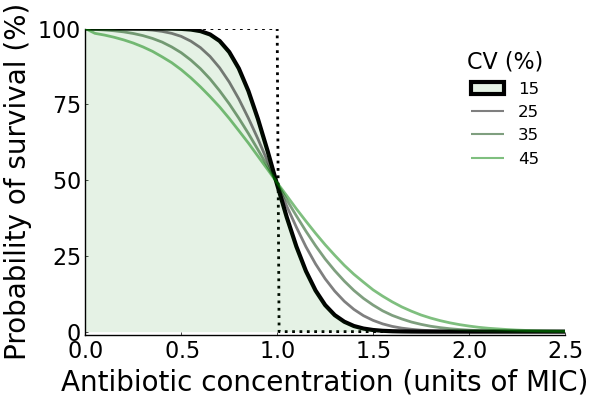

In [41]:


muipBGT=findall(x -> x == 19., mus)[1]
cvipBGT=findall(x -> x == 0.15, cvs)[1]
pBGTcv=cvs[cvipBGT]

cvsl=[.25,.35,.45]
#cvsl=[.20,.25,.30]

cm = cgrad(:linear_ternary_green_0_46_c42_n256)
colors = [cm[i] for i in range(0,stop=1,length=length(cvsl))]
doses=ics

this_probs0=[]
dosesl=collect(0:.01:3)
for x in dosesl
    val=1
    x<=1 ? val=1 : val=0
    push!(this_probs0,val)
end
p=plot(dosesl, 100*this_probs0, alpha=1,label=:none,
            color="black", legend=:none, line=:dot,
            xlabel = "Antibiotic concentration (units of MIC)",ylabel="Probability of survival (%)",
            ylims = (0,100), grid=false, linewidth=2)


i=0

this_probs0=pBGT_cv_ic_sprob[cvipBGT]
plot!(doses, 100*this_probs0, alpha=1.,label=Int(pBGTcv*100),
            color="black", legend=:none, fillalpha=0.1, fillrange=0, fillcolor="green",
            xlabel = "Antibiotic concentration (units of MIC)",ylabel="Probability of survival (%)",
            xtickfontsize=16,ytickfontsize=16,xguidefontsize=20,yguidefontsize=20,legendfontsize=16,
            ylims = (0,100),xlims = (0,2.5), grid=false, linewidth=3)


for cv in cvsl
    global i
    cvi=findall(x -> x == cv, cvs)[1]
    this_probs = pBGT_cv_ic_sprob[cvi]
    i=1+i

    plot!(doses, 100*this_probs, alpha=.5,
          #  color=colors[cvi], legend=:none,
            color=colors[i], legend=:none,label=Int(cv*100),
            xlabel = "Antibiotic concentration (units of MIC)",ylabel="Probability of survival (%)",
            ylims = (-1,100), grid=false, linewidth=2)
end

plot!(leg_title="CV (%)",legend_position=:topright,
    legend_title_font_pointsize=16,legend_font_pointsize=12, fg_legend = :white)
#plot!(size=(2000,1000),dpi=200)

figname=pathFigures*"Fig-1C.pdf"
println("Saving figure $figname ..")
savefig(p,figname)
display(p)
closeall()


## Figure 1B

cv=0.2, cv=0.25, cv=0.35, 
Saving figure /home/charly/Lab/Projects/pBGT/GIT/figures/Fig-1B.pdf ..


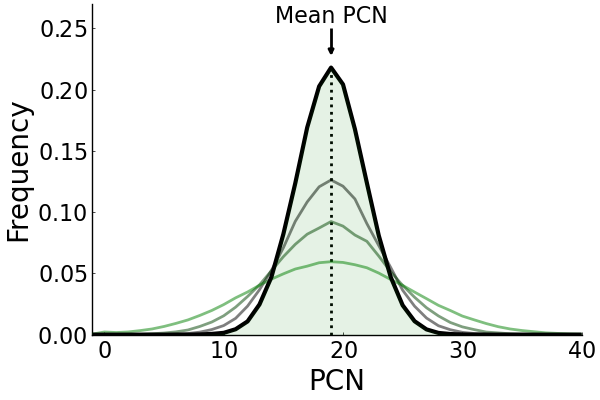

In [30]:
#%%julia
cvsl=[.2,.25,.35]
bins=collect(-1:40)
cm = cgrad(:linear_ternary_green_0_46_c42_n256)
colors = [cm[i] for i in range(0,stop=1,length=length(cvsl))]

ps=plot(size=(600,400))

ps=plot!([pBGTmu, pBGTmu],[0., 0.22], alpha=1,color="black", legend=:none, line=:dot, grid=false, linewidth=2)
i=0
for cv in cvsl
    global i
    i+=1
    cvi=findall(x -> x == cv, cvs)[1]
    this_cv=cvs[cvi]

    print("cv=$(this_cv), ")#
    this_plasmids=pBGT_cv_ic_plasmids_all[cvi][1]

    tp=[x for x in this_plasmids]
    #nfit=fit(Normal, (tp))
    #dist_0=Normal(nfit.μ,nfit.σ)
    k=kde(tp)
    ik=InterpKDE(k)
    dist_0=pdf(ik,bins)
    plot!(bins,dist_0,  fillrange=0, fillalpha=0., alpha=.5,legend=:none,
            color=colors[i], label="$(this_cv)", grid=false, xlims = (0., 40),ylabel="Frequency", xlabel="Plasmid copy number", linewidth=2)
end
println()


this_plasmids=pBGT_cv_ic_plasmids_all[cvipBGT][1]
tp=[x for x in this_plasmids]
#nfit=fit(Normal, (tp))
#dist_0=Normal(nfit.μ,nfit.σ)
k=kde(tp)
ik=InterpKDE(k)
dist_0=pdf(ik,bins)
plot!(bins,dist_0, fillrange=0, fillalpha=0.1, alpha=1,  legend=:none, fillcolor="green",
            xtickfontsize=16,ytickfontsize=16,xguidefontsize=20,yguidefontsize=20,legendfontsize=16,
            color="black", label="$(pBGTcv)", grid=false, xlims = (-1., 40),ylabel="Frequency", xlabel="PCN", linewidth=3,
    ylims=(0,0.27)
    )

annotate!(19, 0.26,text("Mean PCN", :black, :center, 16))
plot!([19,19],[0.25,0.23],arrow=true,color=:black,linewidth=2,label="")

#px=plot(p, ps, layout = grid(1,2,widths = [0.5,0.50], link=:both), size = (1200, 400))
figname=pathFigures*"Fig-1B.pdf"
println("Saving figure $figname ..")
savefig(ps,figname)
display(ps)
closeall()

## Figure 1D

In [31]:
using LaTeXStrings


21
ic=1.0* 
23
ic=1.1* 
25
ic=1.2* 
27
ic=1.3* 
29
ic=1.4* 
31
ic=1.5* 

Saving figure /home/charly/Lab/Projects/pBGT/GIT/figures/Fig-1D.pdf ..


sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


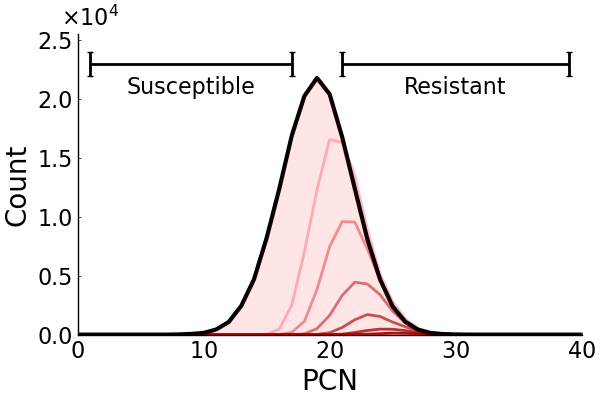

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [32]:

bins=collect(0:40)
cm = cgrad(:reds)

#plot_icis=findall(x -> x%0.5==0 , ics)
plot_icis=[21, 23, 25, 27, 29, 31]
color_icis=[1,2,3,4,5,6]

colors = [cm[i] for i in range(0,stop=1,length=length(plot_icis))]
ps=plot(size=(600,400))
ps=plot!([pBGTmu, pBGTmu],[0., 0.25], alpha=1,color="black", legend=:none, line=:dot, grid=false, linewidth=2)

for i in color_icis
    ici=plot_icis[i]
    this_ic=ics[ici]
    println(ici)


    print("ic=$(this_ic)")#
    this_plasmids=pBGT_cv_ic_plasmids_alive[cvipBGT][ici]
    this_color=colors[i]

    tp=[x for x in this_plasmids]
    meanPCN=mean(this_plasmids)

    isempty(tp) ? (print(" ");continue) : 0
    np=length(tp)
    print("* \n")
    k=kde(tp)
    ik=InterpKDE(k)
    dist_0=pdf(ik,bins)
    plot!(bins,dist_0*np, fillrange=0, fillalpha=0., alpha=.9,legend=:none, color=this_color, label="$(this_ic)", grid=false, ylabel="Frequency", xlabel="Plasmid copy number", linewidth=2)

end
println()


this_plasmids=pBGT_cv_ic_plasmids_all[cvipBGT][1]
tp=[x for x in this_plasmids]
#nfit=fit(Normal, (tp))
#dist_0=Normal(nfit.μ,nfit.σ)
np=length(tp)
k=kde(tp)
ik=InterpKDE(k)
dist_0=pdf(ik,bins)
plot!(bins,dist_0*np,  fillrange=0, fillalpha=0.1, alpha=1, fillcolor="red", legend=:none,
            xtickfontsize=16,ytickfontsize=16,xguidefontsize=20,yguidefontsize=20,legendfontsize=16,
            color="black", label="$(pBGTcv)", grid=false, ylims=(0, 2.55e4), xlims = (0., 40),ylabel="Count", xlabel="PCN", linewidth=3,
    yaxis=(formatter=y->string(round( y / 10^4,digits=2))),
    #formatter = :scientific
    top_margin = 8Plots.mm
)
annotate!([(1, (2.5e4)*1.075, Plots.text(L"\times10^{4}", 16, :black, :center))])

plot!([1,17], [2.3e4, 2.3e4], yerr = [1e3, 1e3],  label = "",line=(2,:solid,:black))
plot!([21,39], [2.3e4, 2.3e4], yerr = [1e3, 1e3],  label = "",line=(2,:solid,:black))
annotate!([(9, (2.1e4), Plots.text("Susceptible", 16, :black, :center))])
annotate!([(30, (2.1e4), Plots.text("Resistant", 16, :black, :center))])

#plot!(size=(2000,1000),dpi=200)

figname=pathFigures*"Fig-1D.pdf"
println("Saving figure $figname ..")
savefig(ps,figname)
display(ps)
closeall()



ic=0.0	meanPCN=18.99346	stdPCN=2.862470814836662
ic=0.05	meanPCN=19.02122	stdPCN=2.865057032088185
ic=0.1	meanPCN=18.99988	stdPCN=2.862813640916825
ic=0.15	meanPCN=18.98783	stdPCN=2.8647415168806476
ic=0.2	meanPCN=18.98259	stdPCN=2.8615570546448628
ic=0.25	meanPCN=18.98705	stdPCN=2.853875215130728
ic=0.3	meanPCN=19.00009	stdPCN=2.862749018901136
ic=0.35	meanPCN=18.992569925699257	stdPCN=2.86252313096706
ic=0.4	meanPCN=19.01885094254713	stdPCN=2.8692801581320944
ic=0.45	meanPCN=19.003270948575086	stdPCN=2.8570383449351033
ic=0.5	meanPCN=19.018845264664378	stdPCN=2.8572626029687873
ic=0.55	meanPCN=19.030751171353753	stdPCN=2.8282191560166834
ic=0.6	meanPCN=19.052462785913107	stdPCN=2.8080599767303602
ic=0.65	meanPCN=19.131998898734565	stdPCN=2.7457195330420374
ic=0.7	meanPCN=19.21664341198276	stdPCN=2.671606941281012
ic=0.75	meanPCN=19.390132925996944	stdPCN=2.5803083481279803
ic=0.8	meanPCN=19.58306091440674	stdPCN=2.4814236629426465
ic=0.85	meanPCN=19.8697144443463	stdPCN=2.3707817737

┌ Warning: Skipped line arg -.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1105


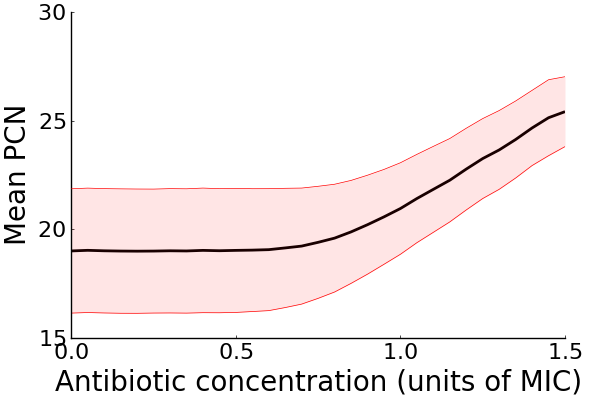

In [ ]:

bins=collect(0:40)
cm = cgrad(:reds)
plot_icis=1:31
meanPCNs=[]
stdPCNs=[]
As=[]
for ici in plot_icis
    this_ic=ics[ici]

    print("\nic=$(this_ic)")#
    this_plasmids=pBGT_cv_ic_plasmids_alive[cvipBGT][ici]

    tp=[x for x in this_plasmids]
    this_meanPCN=mean(this_plasmids)
    this_stdPCN=std(this_plasmids)
    print("\tmeanPCN=$(this_meanPCN)")
    print("\tstdPCN=$(this_stdPCN)")

    append!(meanPCNs, this_meanPCN)
    append!(stdPCNs, this_stdPCN)
    append!(As, this_ic)

end

p=plot(As, meanPCNs, alpha=1,
            xlabel = "Antibiotic concentration (units of MIC)", ylabel="Mean PCN",
            color="black", legend=:none, line=-,
            xtickfontsize=16,ytickfontsize=16,xguidefontsize=20,yguidefontsize=20,legendfontsize=16,
            ylims = (15,30), xlims=(0, ics[last(plot_icis)]), grid=false, linewidth=2)

plot!(As, meanPCNs.-stdPCNs, fillrange = meanPCNs.+stdPCNs, fillalpha = 0.1, c = "red", fillcolor="red", linewidth=0.5)
plot!(As, meanPCNs.+stdPCNs, c = "red", linewidth=0.5)

# figname=pathFigures*"Fig-7F.pdf"
# println("Saving figure $figname ..")
# savefig(p,figname)
# display(p)


## Figure 1E

In [ ]:

bins=collect(0:40)

bin_edges=collect(0:1:30)
cvipBGT=findall(x -> x == 0.25, cvs)[1]
#pBGTcv=cvs[cvipBGT]

#time_Pcounts_bins=normalize_FullTimeSeries(time_Pcounts,time_mins,bin_edges)


cmr = cgrad(:reds)
plot_icis=1:31
meanPCNs=[]
stdPCNs=[]
As=[]
ic_Pcounts=[]
for ici in plot_icis
    this_ic=ics[ici]

    this_plasmids=pBGT_cv_ic_plasmids_alive[cvipBGT][ici]

    this_meanPCN=mean(this_plasmids)
    tp=[x for x in this_plasmids]

    append!(meanPCNs, this_meanPCN)
    push!(ic_Pcounts, this_plasmids)
    #ic_Pcounts=hcat(ic_Pcounts, this_plasmids)
    append!(As, this_ic)

end

as_Pcounts_bins=normalize_FullTimeSeries(ic_Pcounts,As,bin_edges)
;


Saving figure /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/Fig-1E.pdf ..


sys:1: UserWarning: The following kwargs were not used by contour: 'label'


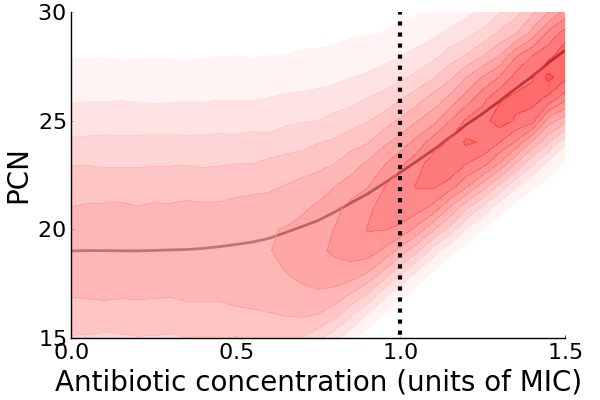

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [ ]:
#%%julia

colGRAD=cgrad([colorant"white",colorant"blue"])
colGRAD=cgrad([colorant"white",colorant"red"])
pdenmax=ceil(maximum(as_Pcounts_bins),digits=1)

p=plot(As, meanPCNs, alpha=1,
            xlabel = "Antibiotic concentration (units of MIC)", ylabel="PCN",
            color="black", legend=:none, #line=-,
            xtickfontsize=16,ytickfontsize=16,xguidefontsize=20,yguidefontsize=20,legendfontsize=16,
            ylims = (15,30), xlims=(0, ics[last(plot_icis)]), grid=false, linewidth=2,label=false)
#heatmap!(p,As,bin_edges,as_Pcounts_bins,colorbar=false, color=colGRAD,alpha=.75)
contour!(p,As,bin_edges,as_Pcounts_bins,colorbar=false,fill=true,lw=0,label=false, color=colGRAD,alpha=.75, clim=(.01,pdenmax))

vline!([1],linestyle=:dot,lw=3,linecolor=:black,label=false)

figname=pathFigures*"Fig-1E.pdf"
println("Saving figure $figname ..")
savefig(p,figname)
display(p)
closeall()



## Figure 1F

### Simulation parameters

In [ ]:
Ndays=3

T=60*6
time_mins=collect(1:T)
iniCells=1000 ############## dilution
starting_variation=true

sim_ICs=[0;collect(.25:.25:.75);collect(.8:.05:.9);collect(.925:.025:1)]
cv=0.3
p_Ndist=Normal(mu,mu*cv)
kNoise_dist=Normal(0.,.001)

@everywhere rep_delay=100
antibiotic_action=.6

0.6

### Run simulations

In [ ]:
aA=0.
R0=1.

time_mins=collect(1:T)
reDo_sim=false;
#reDo_sim=true;

if reDo_sim

    for current_IC in sim_ICs
        this_bst=Bacteria[]
        this_bst=getInitialPopulation(iniCells, mu, 1,starting_variation);
        lid=length(this_bst)
        println("\n\nSim using IC-$(current_IC)")
        println("Time\tTotal\tResource         .\tN alive")

        for day = 1:Ndays
            R0=1.
            aA=0.
            lid=length(this_bst)
            day==2 ? (aA=pMIC*current_IC;println("Introducing antibiotic")) : 0
            day==3 ? (aA=0.;println("Removing antibiotic")) : 0
            for ti in time_mins
                if (ti%30==0)|(ti==1)
                    tparam=0
                    for b in this_bst
                        b.isDead==false ? tparam+=1 : 0
                    end
                    println(ti/60,"\t",length(this_bst),"\t",R0,"\t",tparam,"\t",aA)
                    flush(stdout)
                end

                R0,aA,lid=simulate(ti, this_bst, R0, aA,antibiotic_action,lid)

            end
            sim_file=pathDataLAL*"Transfers_sim-$(T)min_IniCells-$(iniCells)_mu-$(Int(mu))_IC-$(current_IC)_day-$(day).bacsim"
            serialize(sim_file, this_bst);
            tparam=0
            for b in this_bst
                b.isDead==false ? tparam+=1 : 0
            end
            tparam==0 ? (println("None survived, ending sim :(");continue) : 0
            day==Ndays ? continue : 0
            #this_bst=sampleBs(this_bst,T,iniCells)
            iniCells2=Int(ceil(tparam*.001))
            this_bst=sampleBs(this_bst,T,iniCells2)
        end
    end


end


### Analyse simulations
#### Get plasmid time series  and save data

In [ ]:


Ndays=3
time_mins=collect(1:T)

reDo_analysis=false;
#reDo_analysis=true;

if reDo_analysis
    println(sim_ICs)
    for current_IC in sim_ICs
        println("Analizyng ic $current_IC")
        for day=1:Ndays
        #for day=2:2
            sim_file=pathDataLAL*"Transfers_sim-$(T)min_IniCells-$(iniCells)_mu-$(Int(mu))_IC-$(current_IC)_day-$(day).bacsim"
            analys_file=pathDataLAL*"Transfers_p-timeSeries-$(T)min_IniCells-$(iniCells)_mu-$(Int(mu))_IC-$(current_IC)_day-$(day).bacsim"
            if(isfile(analys_file))
                continue
            end
            println("\tGetting file $(sim_file)")
            flush(stdout)
            this_bst=deserialize(sim_file);
            survivors=get_Pseries_survivours_indexs(this_bst)
            killed=get_Pseries_killed_indexs(this_bst,1,time_mins[end])

            println("\tGot $(length(survivors)) founder survivors")
            println("\tGot $(length(killed)) founders killed")


            println("\tCounting simulation plasmids...")
            flush(stdout)
            time_Pcounts=get_timePlamids(time_mins,this_bst)
            analys_file=pathDataLAL*"Transfers_p-timeSeries-$(T)min_IniCells-$(iniCells)_mu-$(Int(mu))_IC-$(current_IC)_day-$(day).bacsim"
            println("\tSaving timeSeries file $(analys_file)")
            serialize(analys_file, time_Pcounts);
            time_PcountsDiv=get_timePlamidsatDivisions(time_mins,this_bst)
            analys_fileD=pathDataLAL*"Transfers_p-timeSeriesDivs-$(T)min_IniCells-$(iniCells)_mu-$(Int(mu))_IC-$(current_IC)_day-$(day).bacsim"
            println("\tSaving timeSeries file $(analys_fileD)")
            serialize(analys_fileD, time_PcountsDiv);
            this_bst=[]
            println("\tDone")
        end
    end
end


### Read simulation analyzed data
##### Join days plasmids time series

In [ ]:

MNdays_time_Pcounts=[]
MNdays_time_PcountsDiv=[]
Ndays_time_mins=collect(1:time_mins[end]*Ndays)

for current_IC in sim_ICs
    Ndays_time_Pcounts=[]
    Ndays_time_PcountsDiv=[]

    time_Pcounts=[]
    for day=1:Ndays
        analys_file=pathDataLAL*"Transfers_p-timeSeries-$(T)min_IniCells-$(iniCells)_mu-$(Int(mu))_IC-$(current_IC)_day-$(day).bacsim"
        println("Reading $analys_file ...")
        flush(stdout)
        time_Pcounts=deserialize(analys_file);
        analys_fileD=pathDataLAL*"Transfers_p-timeSeriesDivs-$(T)min_IniCells-$(iniCells)_mu-$(Int(mu))_IC-$(current_IC)_day-$(day).bacsim"
        println("Reading $analys_fileD ...")
        flush(stdout)
        time_PcountsDiv=deserialize(analys_fileD);
        println("done!")
        flush(stdout)
        Ndays_time_Pcounts=vcat(Ndays_time_Pcounts,time_Pcounts)
        Ndays_time_PcountsDiv=vcat(Ndays_time_PcountsDiv,time_PcountsDiv)
        GC.gc()
    end
    push!(MNdays_time_Pcounts,Ndays_time_Pcounts)
    push!(MNdays_time_PcountsDiv,Ndays_time_PcountsDiv)
end



Reading /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/data/sim_data/LB-AMP-LB/Transfers_p-timeSeries-360min_IniCells-1000_mu-19_IC-0.0_day-1.bacsim ...
Reading /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/data/sim_data/LB-AMP-LB/Transfers_p-timeSeriesDivs-360min_IniCells-1000_mu-19_IC-0.0_day-1.bacsim ...
done!
Reading /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/data/sim_data/LB-AMP-LB/Transfers_p-timeSeries-360min_IniCells-1000_mu-19_IC-0.0_day-2.bacsim ...
Reading /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/data/sim_data/LB-AMP-LB/Transfers_p-timeSeriesDivs-360min_IniCells-1000_mu-19_IC-0.0_day-2.bacsim ...
done!
Reading /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/data/sim_data/LB-AMP-LB/Transfers_p-timeSeries-360min_IniCells-1000_mu-19_IC-0.0_day-3.bacsim ...
Reading /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/data/sim_data/LB-AMP-LB/Transfers_p-timeSeriesDivs-360min_IniCells-1000_mu-19_IC-0.0_day-3.bacsim ...
done!
Reading /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/data

### Getting plasmid time series distributions

In [ ]:
MNtime_Pcounts_bins=[]
MNtime_PcountsDiv_bins=[]
MNtime_Pcounts_binsNormed=[]
MNtime_PcountsDiv_binsNormed=[]

bin_edges=[0;collect(10:3:34)]
bin_edges=[0;collect(10:3:41)]


for (Ndays_time_Pcounts,Ndays_time_PcountsDiv) in zip(MNdays_time_Pcounts,MNdays_time_PcountsDiv)
    norm=false
    Ntime_Pcounts_bins=binarize_timePcounts(Ndays_time_Pcounts,Ndays_time_mins,bin_edges,norm)
    Ntime_PcountsDiv_bins=binarize_timePcounts(Ndays_time_PcountsDiv,Ndays_time_mins,bin_edges,norm)

    norm=true
    Ntime_Pcounts_binsNormed=binarize_timePcounts(Ndays_time_Pcounts,Ndays_time_mins,bin_edges,norm)
    Ntime_PcountsDiv_binsNormed=binarize_timePcounts(Ndays_time_PcountsDiv,Ndays_time_mins,bin_edges,norm)

    push!(MNtime_Pcounts_bins,Ntime_Pcounts_bins)
    push!(MNtime_PcountsDiv_bins,Ntime_PcountsDiv_bins)
    push!(MNtime_Pcounts_binsNormed,Ntime_Pcounts_binsNormed)
    push!(MNtime_PcountsDiv_binsNormed,Ntime_PcountsDiv_binsNormed)
end



### Plot Figure 1F

In [ ]:
##### sim_ICs=collect(.5:.1:1)


tend=Int(time_mins[end])
th=6
tpp=Int(60*th)
println(tend)


thisEndDict=1
Ndays=3

function getThisDictMean(thisEndDict0)
    pcncells=0
    ncels=0
    for (pcn,timespcn) in sort(collect(thisEndDict0))
        #println(pcn,"-",timespcn)
        st=pcn*timespcn
        #st>0 ? (pcncells+=st;ncels+=timespcn) : 0
        timespcn>0 ? (pcncells+=st;ncels+=timespcn) : 0

    end
    thismean=(pcncells/ncels)

end

ncolors=length(sim_ICs)
tcgrad=cgrad(:heat,ncolors )# )



360


["sans-serif"]
/content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/Fig-1F.pdf

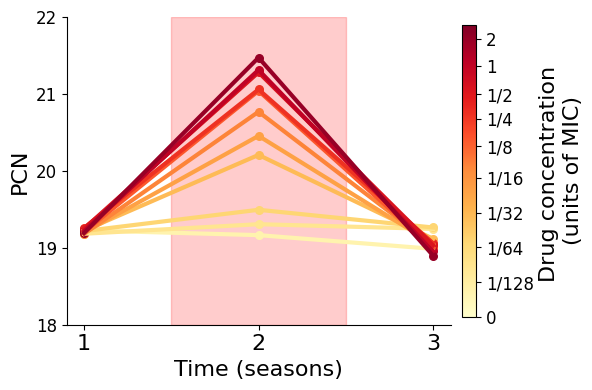

In [ ]:

c_m = mpl.cm.YlOrRd
normp = mpl.colors.Normalize(vmin=np.min(sim_ICs),vmax=np.max(sim_ICs)+.05)
s_mp = mpl.cm.ScalarMappable(cmap=c_m, norm=normp)
s_mp.set_array([])


fig,ax=plt.subplots(figsize=(6,4))
plt.rcParams["font.size"]= 16
fig.set_facecolor("white")
fontfam=plt.rcParams["font.family"]
println(fontfam)
ax.axvspan(xmin=1.5, xmax=2.5,ymin=0, ymax=1, color="red",alpha=0.2,zorder=0)

for (i,Ndays_time_Pcounts) in enumerate(MNdays_time_Pcounts)
    thisICmeans=[]
    thisIC=sim_ICs[i]
    tc=s_mp.to_rgba(thisIC)
    tc=s_mp.to_rgba(i/length(sim_ICs))
    for day=1:Ndays
        tfinal=tend*(day-1)+tpp
        #println(tfinal)
        thisEndDict=Ndays_time_Pcounts[tfinal]
        #display(thisEndDict[0])
        tm=getThisDictMean(thisEndDict)
        #print(tm)
        push!(thisICmeans,tm)
    end
    plt.plot([1,2,3],thisICmeans,label=false,c=tc,lw=3 )
    plt.scatter([1,2,3], thisICmeans,color=tc,s=30)
end

ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)


#normp = mpl.colors.Normalize(vmin=np.min(sim_ICs)-.05,vmax=np.max(sim_ICs)+.05)
#s_mp = mpl.cm.ScalarMappable(cmap=c_m, norm=normp)
#s_mp.set_array([])



cbar=plt.colorbar(s_mp,shrink=.95,fraction=.1,pad=.025)
cbar.ax.set_ylabel("Drug concentration \n(units of MIC)",fontsize=16)

#color number trick
cbtick=[0,0.125,.25,0.375,.5,0.6125,.7125,0.8,.9,1]
cbtickl=["0","1/128","1/64","1/32","1/16","1/8","1/4","1/2","1","2"]

cbar.ax.set_yticks(cbtick)
cbar.ax.set_yticklabels(cbtickl,fontsize=12)

plt.ylim([18,22])
plt.yticks([18,19,20,21,22],fontsize=12)

plt.xlabel("Time (seasons)",fontsize=16);
plt.ylabel("PCN",fontsize=16);
plt.xticks([1,2,3],fontsize=16)
plt.tight_layout()

figname=pathFigures*"Fig-1F.pdf"
print(figname)
plt.savefig(figname,bbox_inches = "tight",pad_inches = 0.1)
plt.show()
